In [3]:
import os
from skimage.io import imread
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import cv2 as cv

import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn.functional as F

from resnet_model.data_loading import ImageLabelDataset
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv
from pathlib import Path

from torchvision import models


## Color detection of ants
This project aims at deteting the color of ants in images.

![alt text](ants_color_wheel.jpg "Ants color wheel")


### Data
**Information from lab:** \
FOR PROJECT on COULOUR DETECTION
In colour_digitalization.zip --> an excel file with 28770 spécimens and the information relative to the "human being digitalization". 
Column names are mostly explicit. Last column max_distance corresponds to the maximum distance among the six distances between colours observed on head-thorax-abdomen (six couples: head-thorax; thorax-abdomen, etc). If the distance is small (<30), we could consider the specimen as homogeneous in terms of colour variation.


**original** \
This folder contains 38578 images of ants. \
In these images there is the measurement stick 

**colour_digitalization.xlsx** \
Contains data about each ant. \
Specimen is the unique identifier of each ant and this is also used as file name for each ant image. \
In this file we have the RGB values for each of the body parts of the ant head, thorax, abdomen and the x,y coordinates where these values have been taken \

**Some maybe useful links:**

https://medium.com/@rajat01221/the-mathematics-behind-color-detection-in-machine-learning-algorithms-fc79a8eddf98

https://towardsdatascience.com/color-identification-in-images-machine-learning-application-b26e770c4c71

https://link.springer.com/chapter/10.1007/978-3-031-19647-8_5





#### Reading in some ant images from original folder 

In [4]:
def read_image_file_names(folder_path):
    # List all files in the folder and sort them
    all_files = sorted(os.listdir(folder_path))

    # Filter only the image files (e.g., with extensions .jpg, .png)
    image_file_names = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    return image_file_names


In [5]:
def clean_file_name_png(file_names):
    """
    Extracting specimen name from png files
    """
    cleaned_file_names = [file.replace('_p_1.png', '') for file in file_names]

    return cleaned_file_names

def clean_file_name_jpg(file_names):
    """
    Extracting specimen name from jpg files
    """
    cleaned_file_names = [file.replace('_p_1.jpg', '') for file in file_names]

    return cleaned_file_names

def clean_file_name_mask(file_names):
    """
    Extracting specimen name from jpg files
    """
    cleaned_file_names = [file.replace('_msk', '') for file in file_names]
    cleaned_file_names = [file.replace('_p.png', '') for file in cleaned_file_names]

    return cleaned_file_names

def add_jpg(cleaned_file_names):
    file_names = [file + '_p_1.jpg' for file in cleaned_file_names]

    return file_names


In [6]:
# Path to the folder containing images
folder_path_img = '/Volumes/T7 Shield/AntProject/original'
image_file_names = read_image_file_names(folder_path_img)

folder_path_ants = '/Volumes/T7 Shield/AntProject/without_background'
ant_file_names = read_image_file_names(folder_path_ants)

folder_path_mask = '/Volumes/T7 Shield/AntProject/muticlass_model/masks_4_categories/masks_4_categories'
mask_file_names = read_image_file_names(folder_path_mask)

path_df = '/Volumes/T7 Shield/AntProject/colour_ants.csv'

In [7]:
# Read the Excel file
df = pd.read_csv(path_df)
df.head()

,specimen,original_file,species,x_head,y_head,x_thorax,y_thorax,x_abdomen,y_abdomen,r_head,g_head,b_head,r_thorax,g_thorax,b_thorax,r_abdomen,g_abdomen,b_abdomen,max_distance
0,casent0280684,casent0280684_p_1.jpg,Acanthognathus brevicornis,541.761428,611.801353,710.781834,634.915325,1186.833259,449.712645,108,54,18,82,37,16,91,52,21,15.64
1,casent0914659,casent0914659_p_1.jpg,Acanthognathus brevicornis,343.088620,585.595543,569.682016,656.890638,1071.440567,336.927097,119,68,15,118,74,37,166,129,77,26.18
2,usnment00445715,usnment00445715_p_1.jpg,Acanthognathus lentus,401.710873,565.733114,689.236409,515.149918,859.621911,256.909390,226,205,138,203,149,75,206,164,88,30.90
3,casent0178718,casent0178718_p_1.jpg,Acanthognathus ocellatus,161.119440,600.342669,318.193575,661.574959,898.569193,390.023064,153,108,79,113,69,40,149,105,58,18.46
4,casent0914660,casent0914660_p_1.jpg,Acanthognathus ocellatus,477.114498,653.588138,796.587315,637.614498,1116.060132,339.439868,142,89,39,107,68,29,110,68,28,17.92


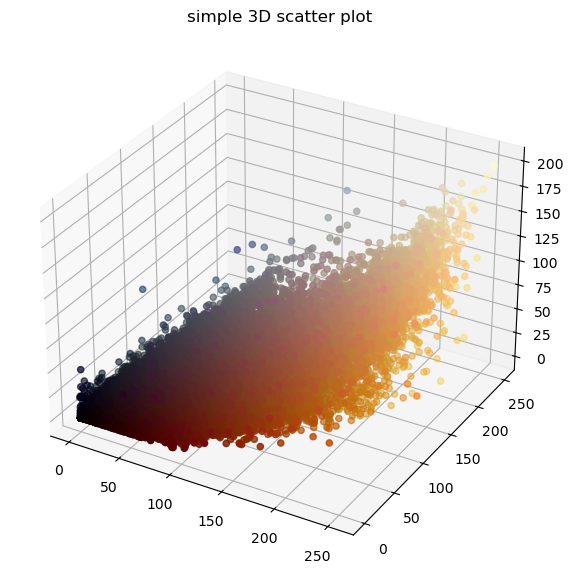

In [8]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

colors = list(zip(df['r_thorax']/255, df['g_thorax']/255, df['b_thorax']/255))

 
# Creating plot
ax.scatter3D(df['r_thorax'], df['g_thorax'], df['b_thorax'], color = colors)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

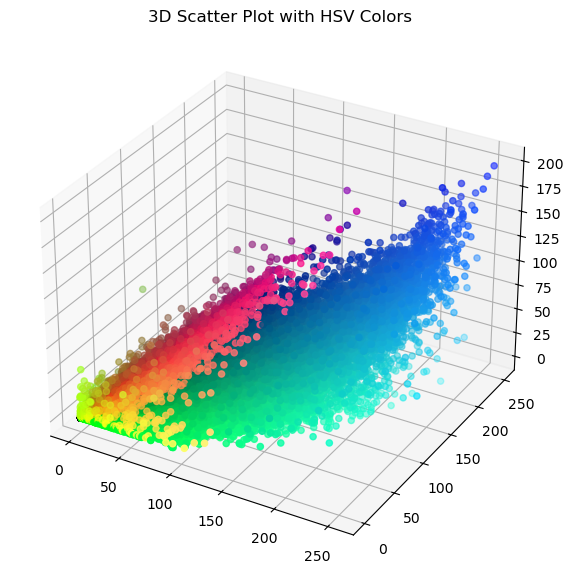

In [9]:
rgb_normalized = np.array(list(zip(df['r_thorax']/255, df['g_thorax']/255, df['b_thorax']/255)))
hsv_normalized = rgb_to_hsv(rgb_normalized)

# Re-normalize HSV values to RGB for plotting
hsv_colors = [tuple(c) for c in hsv_normalized]

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")

ax.scatter3D(df['r_thorax'], df['g_thorax'], df['b_thorax'], color=hsv_colors)
plt.title("3D Scatter Plot with HSV Colors")

# Show plot
plt.show()

In [10]:
# Count unique combinations of R, G, B
unique_combinations = df[['r_thorax','g_thorax','b_thorax']].drop_duplicates().shape[0]

#Most values are unique!
print(f"Number of unique combinations: {unique_combinations}")

Number of unique combinations: 22203


In [11]:
image_file_specimen = clean_file_name_jpg(image_file_names)

ant_file_specimen = clean_file_name_png(ant_file_names)

mask_file_specimen = clean_file_name_mask(mask_file_names)

In [12]:
#Number of images in folder
print('Number of images (.jpg):',len(image_file_names))
print('Number of images (.png):',len(ant_file_names))
print('Number of masks:',len(mask_file_names))
print('Number of rows in df', len(df))

Number of images (.jpg): 38578
Number of images (.png): 38578
Number of masks: 210
Number of rows in df 28770


Number of images, masks and rows in dataframe are all different. We need to filter out images which are in dataframe. Then filter out which ones are in masks. So there are ants which are not in the df but which have masks! These ants will be included in the training of the segmentation model!

In [13]:
#Filtering out values which are not in df
specimen_set = set(df['specimen'])  # Convert to a set for faster lookup

filtered_image_file_names = [file for file in image_file_specimen if file in specimen_set]

filtered_ant_file_names = [file for file in ant_file_specimen if file in specimen_set]

print(len(filtered_image_file_names))  # Number of filtered elements
print(len(filtered_ant_file_names))

28770
28770


### Creating datasets

In [14]:
#filtering out ants which are in masks
specimen_set = set(mask_file_specimen)  # Convert to a set for faster lookup

filtered_image_file_names = [file for file in image_file_specimen if file in specimen_set]

filtered_ant_file_names = [file for file in ant_file_specimen if file in specimen_set]

print(len(filtered_image_file_names))  # Number of filtered elements
print(len(filtered_ant_file_names))


190
190


In [15]:
not_in_specimen_set = set(mask_file_specimen) - set(filtered_ant_file_names)

print("Files in filtered_ant_file_names but not in masks:")
print(not_in_specimen_set)

Files in filtered_ant_file_names but not in masks:
{'casent0910205', 'antweb1008479', 'casent0907494', 'casent0904088', 'casent0120949', 'casent0129573', 'casent0172183', 'casent0281801', 'casent0082404', 'casent0908402', 'casent0173334', 'ecofog-sg17-0042-03', 'casent0264059', 'casent0178880', 'casent0249819', 'casent0794348', 'casent0179545', 'casent0172470', 'casent0424548', 'casent0217756'}


Nothing strange with these ids checked one manually and it was not in the image set. 

In [16]:
def read_images(file_names, folder_path_img):

    # Reading in the 100 images
    images = []
    for file in file_names:
        image_path = os.path.join(folder_path_img, file)
        
        if file.startswith('._'):
            continue
        try:
            img = imread(image_path)
            images.append(img)
        except Exception as e:
            print(f"Error reading {file}: {e}")

    return images

In [17]:
#Extracting images with masks from a given folder 
images_with_mask = add_jpg(filtered_image_file_names)

images = read_images(images_with_mask, folder_path_img)

### Reading in masks which are in images


In [26]:
#Reading all masks
masks = read_images(mask_file_names, folder_path_mask)

In [27]:
#Filtering out masks not in images

in_filtered_ant_indexes = [index for index, file in enumerate(mask_file_specimen) if file in filtered_ant_file_names]

masks_filtered = [masks[i] for i in in_filtered_ant_indexes]


### Looking at images

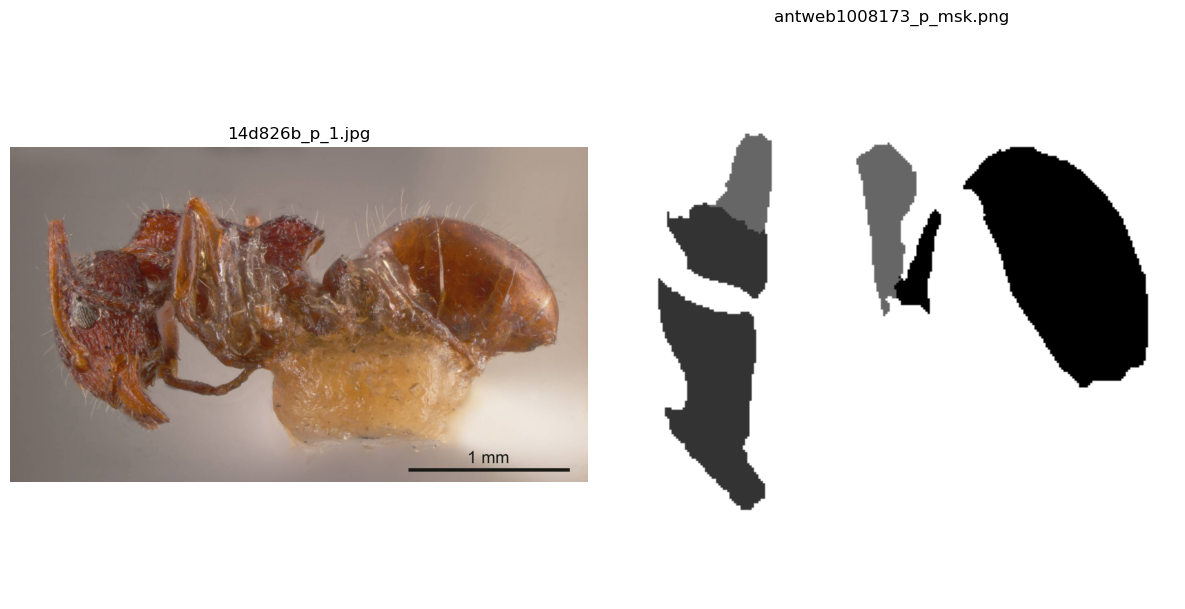

In [43]:
index = 4
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(images[index])
ax[0].axis('off') 
ax[0].set_title(image_file_names[index])

ax[1].imshow(masks_filtered[index], cmap='gray')
ax[1].axis('off') 
ax[1].set_title(mask_file_names[index])

plt.tight_layout()
plt.show()

### Looking at images in different color spaces/channels

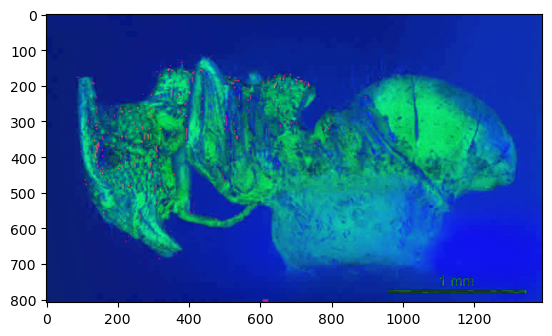

In [48]:
image_ant_hsv = cv.cvtColor(images[index], cv.COLOR_RGB2HSV)
plt.imshow(image_ant_hsv)

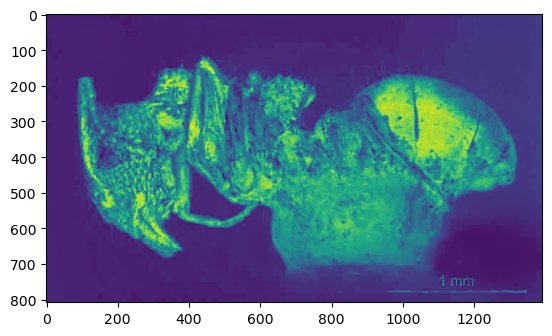

In [49]:
plt.imshow(image_ant_hsv[:,:,1])

In [50]:
def get_color_value(index):

    color_value = df[['r_thorax', 'g_thorax', 'b_thorax']].iloc[index]

    #Plotting thorax color value
    color = (color_value.iloc[0] / 255, color_value.iloc[1] / 255, color_value.iloc[2] / 255)

    # Display the color as a patch
    plt.figure(figsize=(2, 2))
    plt.imshow([[color]])
    plt.axis('off')
    plt.show()

### Downloading images with masks to give to others
Downloading both masks and images

In [18]:
# Specify the directories where you want to save the images
images_dir = 'images_folder/'
masks_dir = 'masks_folder/'

# Create the directories if they don't exist
os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

# Iterate through the images and masks and save them
for index, image in enumerate(images):
    # Save the image (images_with_mask) as a file
    image_path = os.path.join(images_dir, f'image_{index}.png')  # or .png
    Image.fromarray(image).save(image_path)  # Assuming the images are numpy arrays

    # Save the mask (masks_filtered) as a file
    mask_path = os.path.join(masks_dir, f'mask_{index}.png')  # or .png
    Image.fromarray(masks_filtered[index]).save(mask_path)  # Assuming masks_filtered is a list of numpy arrays


NameError: name 'masks_filtered' is not defined

### Starting creating ML model
Prepare the data set for training:
- Resize, normalize
- Make sure masks and images are connected
- Implement data augmentation for data and masks?

In [16]:
class ImageMaskDataset(Dataset):
    SPLITS = {
        'train': list(range(0, 150)), 
        'val':   list(range(150, 170)),
        'test':  list(range(170, 190))
    }
    
    def __init__(self, images_dir, masks_dir, transform=None, split='train'):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        
        # Validate split
        if split not in self.SPLITS:
            raise ValueError(f"Invalid split '{split}'. Choose from {list(self.SPLITS.keys())}.")
        
        # Filter filenames based on the split
        indices = self.SPLITS[split]
        self.image_filenames = [sorted(os.listdir(images_dir))[i] for i in indices]
        self.mask_filenames = [sorted(os.listdir(masks_dir))[i] for i in indices]
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        # Load the image and the corresponding mask
        img_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Masks are grayscale
        
        # Apply transformation, if provided
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

In [22]:
# Directories for images and masks
images_dir = 'images_folder/'
masks_dir = 'masks_folder/'

# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images and masks to a fixed size
    transforms.ToTensor()          # Convert images to tensors
])

/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


Image shape: torch.Size([3, 256, 256]), Mask shape: torch.Size([1, 256, 256])


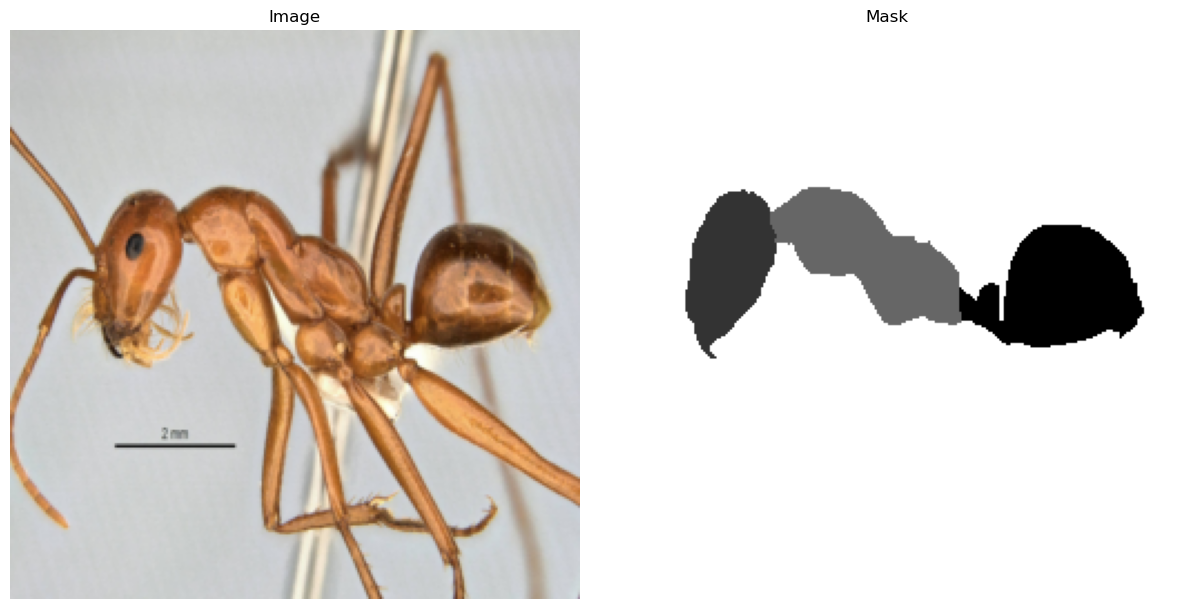

In [18]:
# Create datasets for train, val, and test splits
train_dataset = ImageMaskDataset(images_dir, masks_dir, transform=transform, split='train')
val_dataset = ImageMaskDataset(images_dir, masks_dir, transform=transform, split='val')
test_dataset = ImageMaskDataset(images_dir, masks_dir, transform=transform, split='test')


# Example: Iterating through the DataLoader
for img, mask in train_dataset:
    print(f"Image shape: {img.shape}, Mask shape: {mask.shape}")

    # Convert tensors to numpy arrays for visualization
    img_np = img.permute(1, 2, 0).numpy()
    mask_np = mask.squeeze().numpy()

    # Plot the image and mask
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img_np)
    ax[0].set_title("Image")
    ax[0].axis("off")
    
    ax[1].imshow(mask_np, cmap="gray")
    ax[1].set_title("Mask")
    ax[1].axis("off")
    
    plt.tight_layout()
    plt.show()
    break #To only plot one example

### Preparing Label image dataset

In [19]:
df.head()

,specimen,original_file,species,x_head,y_head,x_thorax,y_thorax,x_abdomen,y_abdomen,r_head,g_head,b_head,r_thorax,g_thorax,b_thorax,r_abdomen,g_abdomen,b_abdomen,max_distance
0,casent0280684,casent0280684_p_1.jpg,Acanthognathus brevicornis,541.761428,611.801353,710.781834,634.915325,1186.833259,449.712645,108,54,18,82,37,16,91,52,21,15.64
1,casent0914659,casent0914659_p_1.jpg,Acanthognathus brevicornis,343.088620,585.595543,569.682016,656.890638,1071.440567,336.927097,119,68,15,118,74,37,166,129,77,26.18
2,usnment00445715,usnment00445715_p_1.jpg,Acanthognathus lentus,401.710873,565.733114,689.236409,515.149918,859.621911,256.909390,226,205,138,203,149,75,206,164,88,30.90
3,casent0178718,casent0178718_p_1.jpg,Acanthognathus ocellatus,161.119440,600.342669,318.193575,661.574959,898.569193,390.023064,153,108,79,113,69,40,149,105,58,18.46
4,casent0914660,casent0914660_p_1.jpg,Acanthognathus ocellatus,477.114498,653.588138,796.587315,637.614498,1116.060132,339.439868,142,89,39,107,68,29,110,68,28,17.92


In [19]:
shuffled_df = df.sample(frac=1).reset_index(drop=True)
shuffled_df.head()

total_len = len(shuffled_df)
train_size = int(total_len * 0.7)  # 70% for training
val_size = int(total_len * 0.1)    # 10% for validation
test_size = total_len - train_size - val_size  # Remaining 20% for testing

# Create the split ranges


In [20]:
"""
class ImageLabelDataset(Dataset):
    #SPLITS = {
    #'train': list(range(0, train_size)),
    #'val': list(range(train_size, train_size + val_size)),
    #'test': list(range(train_size + val_size, total_len))}
    SPLITS = {
        'train': list(range(0, 150)), 
        'val':   list(range(150, 170)),
        'test':  list(range(170, 190))
    }
    
    def __init__(self, images_dir, transform=None, split='train'):
        self.images_dir = images_dir
        self.transforms = transform

        self.data = []  # list of tuples of (image path, label class)
        for imgIndex in self.SPLITS[split]:
            row = df.iloc[imgIndex]
            imgName = os.path.join(images_dir, row['original_file'])

            rgb_value = (row['r_thorax'],row['g_thorax'],row['b_thorax'])
            self.data.append((
                imgName,
                rgb_value
            ))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        imgName, label = self.data[index]
        img = Image.open(imgName)

        if self.transforms is not None:
            img = self.transforms(img)
        return img, label
    
"""

"\nclass ImageLabelDataset(Dataset):\n    #SPLITS = {\n    #'train': list(range(0, train_size)),\n    #'val': list(range(train_size, train_size + val_size)),\n    #'test': list(range(train_size + val_size, total_len))}\n    SPLITS = {\n        'train': list(range(0, 150)), \n        'val':   list(range(150, 170)),\n        'test':  list(range(170, 190))\n    }\n    \n    def __init__(self, images_dir, transform=None, split='train'):\n        self.images_dir = images_dir\n        self.transforms = transform\n\n        self.data = []  # list of tuples of (image path, label class)\n        for imgIndex in self.SPLITS[split]:\n            row = df.iloc[imgIndex]\n            imgName = os.path.join(images_dir, row['original_file'])\n\n            rgb_value = (row['r_thorax'],row['g_thorax'],row['b_thorax'])\n            self.data.append((\n                imgName,\n                rgb_value\n            ))\n    \n    def __len__(self):\n        return len(self.data)\n    \n    def __getitem

In [23]:
images_dir = '/Volumes/T7 Shield/AntProject/original'
train_dataset = ImageLabelDataset(images_dir,df,transform, split='train')
val_dataset = ImageLabelDataset(images_dir,df,transform, split='val')

print(f"Train dataset length {len(train_dataset)}")
print(f"Validation dataset length {len(val_dataset)}")

File is empty: /Volumes/T7 Shield/AntProject/original/casent0246027_p_1.jpg
File is empty: /Volumes/T7 Shield/AntProject/original/ecofog-it14-0408-05_p_1.jpg
File is empty: /Volumes/T7 Shield/AntProject/original/casent0914736_p_1.jpg
Train dataset length 23014
Validation dataset length 2876


Image shape: torch.Size([3, 256, 256])


/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


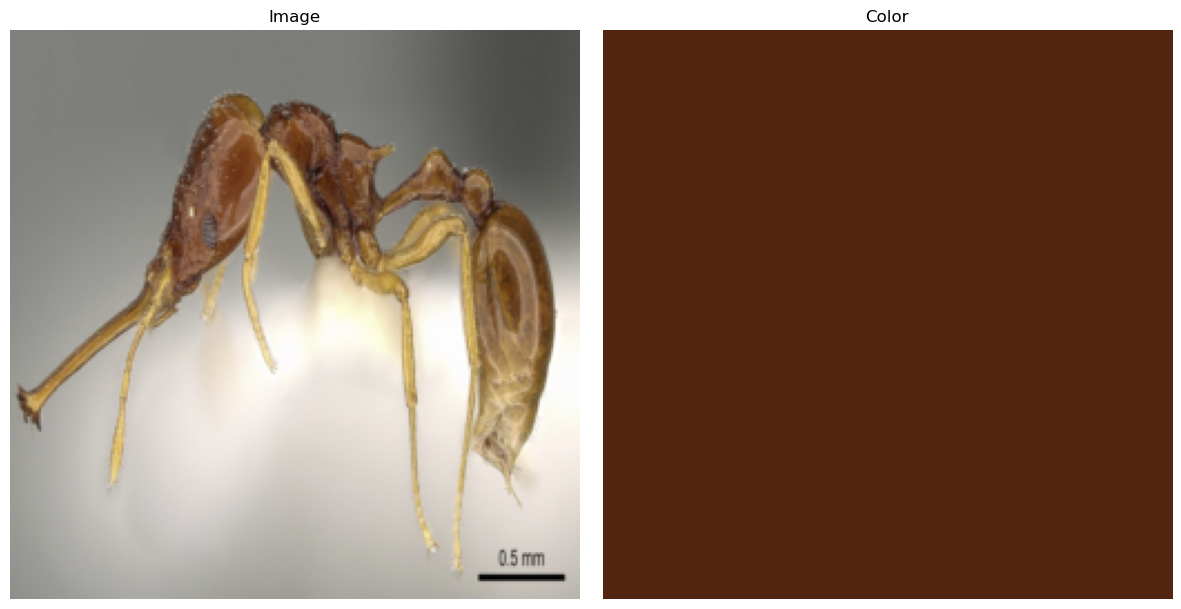

In [24]:
for img, label in train_dataset:
    print(f"Image shape: {img.shape}")

    # Convert tensors to numpy arrays for visualization
    img_np = img.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img_np)
    ax[0].set_title("Image")
    ax[0].axis("off")

    rgb_image = np.ones((10, 10, 3), dtype=int) * np.array(label)/255

    ax[1].imshow(rgb_image)
    ax[1].set_title("Color")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()
    break

### Testing using Gradient boosting regression

In [48]:
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor

images_dir = '/Volumes/T7 Shield/AntProject/original'
train_dataset = ImageLabelDataset(images_dir,df,transform, split='train')
val_dataset = ImageLabelDataset(images_dir,df,transform, split='val')

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

File is empty: /Volumes/T7 Shield/AntProject/original/casent0246027_p_1.jpg
File is empty: /Volumes/T7 Shield/AntProject/original/ecofog-it14-0408-05_p_1.jpg
File is empty: /Volumes/T7 Shield/AntProject/original/casent0914736_p_1.jpg


In [49]:
#Looking at empty files:
file_paths = [
    "/Volumes/T7 Shield/AntProject/original/casent0246027_p_1.jpg",
    "/Volumes/T7 Shield/AntProject/original/ecofog-it14-0408-05_p_1.jpg",
    "/Volumes/T7 Shield/AntProject/original/casent0914736_p_1.jpg",
]

for file_path in file_paths:
    if os.path.exists(file_path):
        size = os.path.getsize(file_path)
        print(f"{file_path} exists with size {size} bytes.")
    else:
        print(f"{file_path} does not exist.")


/Volumes/T7 Shield/AntProject/original/casent0246027_p_1.jpg exists with size 0 bytes.
/Volumes/T7 Shield/AntProject/original/ecofog-it14-0408-05_p_1.jpg exists with size 0 bytes.
/Volumes/T7 Shield/AntProject/original/casent0914736_p_1.jpg exists with size 0 bytes.


In [25]:
from tqdm import tqdm
import xgboost
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor


def prepare_data_boost(data_set, break_threshold):
    x = []
    y = []

    for i, (images, labels) in enumerate(data_set):
        channels = images.size(1)  
        flattened_channels = images.view(images.size(0), -1).numpy()
        x.append(flattened_channels)
        y.append(labels.numpy())


        if i == break_threshold:
            break

    # Combine batches into single array
    x = np.array(x)
    y = np.array(y)

    return x,y

In [28]:
def prepare_data(data_set,break_threshold):
    x = []
    y = []
    
    for i, (images, labels) in enumerate(data_set):
        images_np = images.numpy()
        images_np_flat = images_np.reshape(-1)

        x.append(images_np_flat)
        y.append(labels.numpy())

        if i == break_threshold:
            break

    # Combine batches into single array
    x = np.array(x)
    y = np.array(y)

    return x,y

In [29]:
x_tr,y_tr = prepare_data(train_dataset, 100)

In [31]:
np.shape(x_tr)

(101, 196608)

In [72]:
x_tr,y_tr = prepare_data_boost(train_dataset, 100)
x_tr_reshaped = x_tr.reshape(x_tr.shape[0], -1)

In [74]:
np.shape(x_tr_reshaped)

(303, 65536)

In [68]:
x_te,y_te = prepare_data_boost(val_dataset, 10)
#x_te_reshaped = x_te.reshape(x_te.shape[0], -1)

In [69]:
print(x_te.shape)
print(y_te.shape)

(33, 65536)
(33,)


In [70]:
xgb_regr = MultiOutputRegressor(xgboost.XGBRegressor(objective='reg:squarederror', random_state=0))
xgb_regr.fit(x_tr,y_tr)

# Make predictions
y_pred = xgb_regr.predict(x_te)

# Evaluate performance
mse = mean_squared_error(y_te, y_pred, multioutput='raw_values')
print("Mean Squared Errors for each target:", mse)

ValueError: y must have at least two dimensions for multi-output regression but has only one.

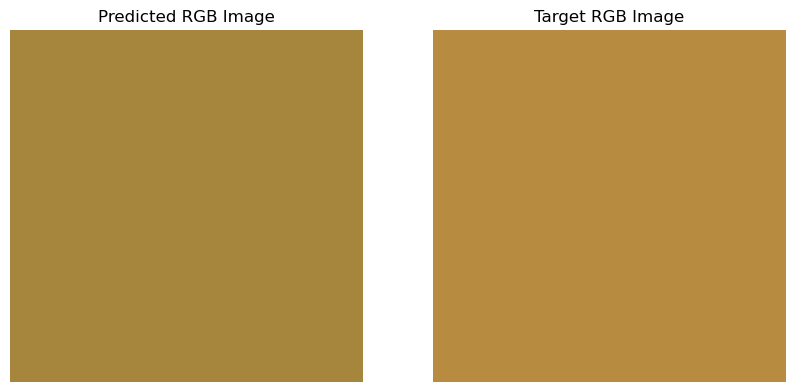

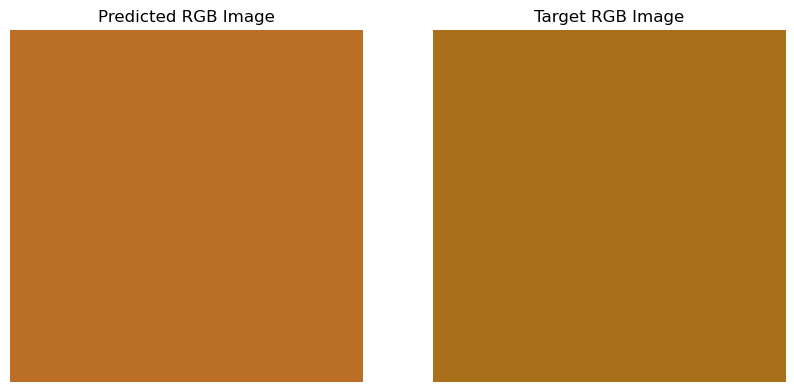

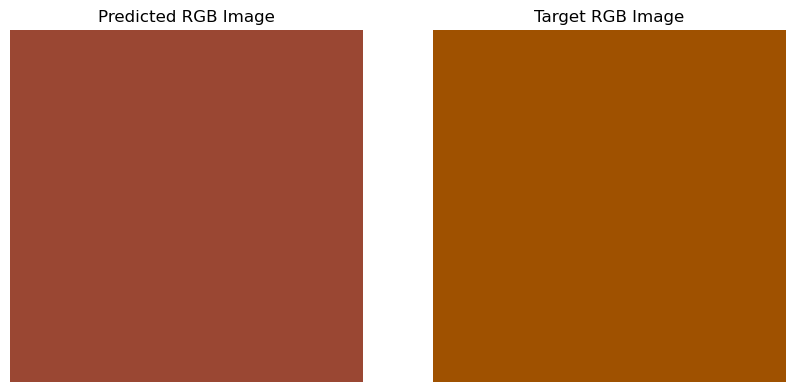

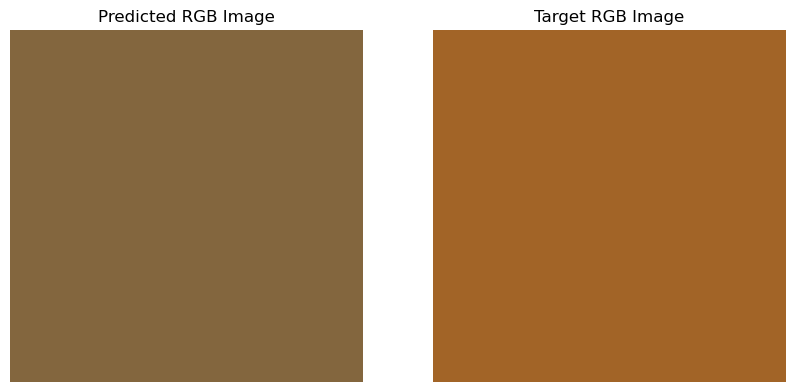

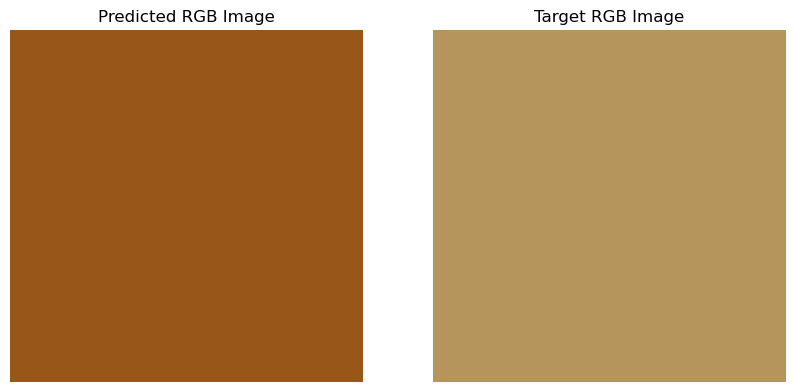

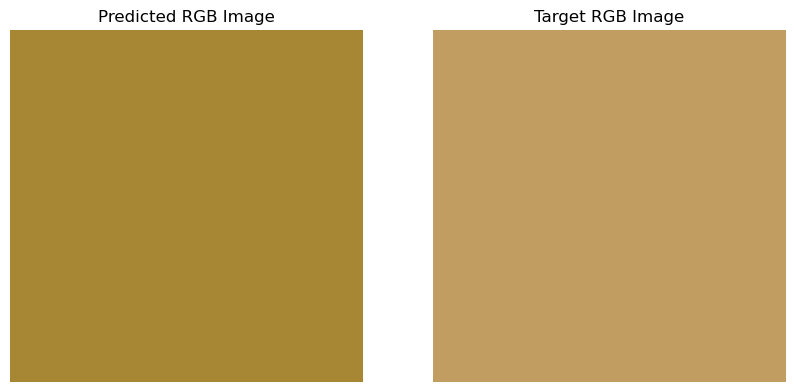

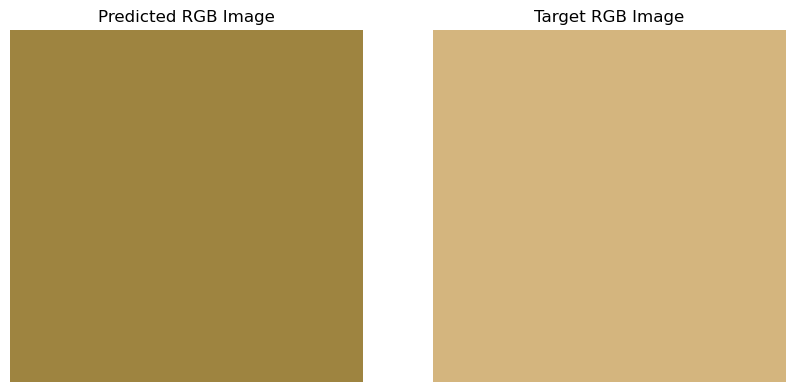

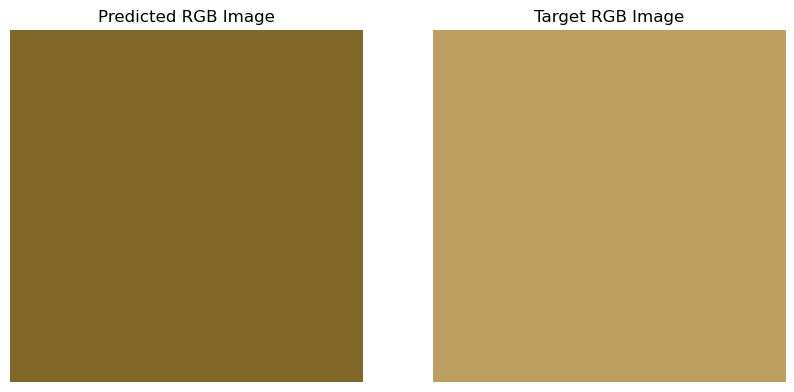

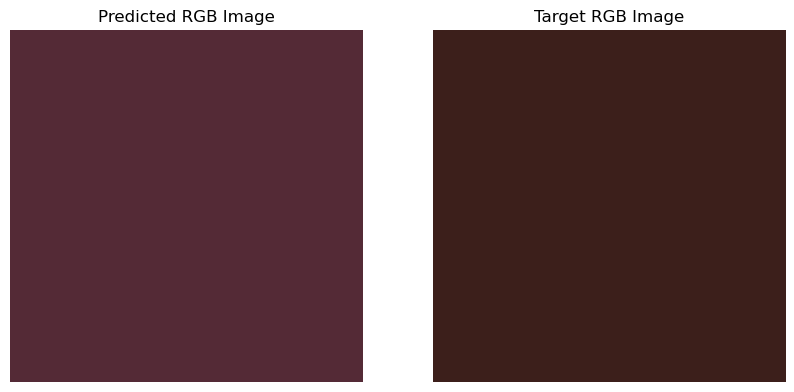

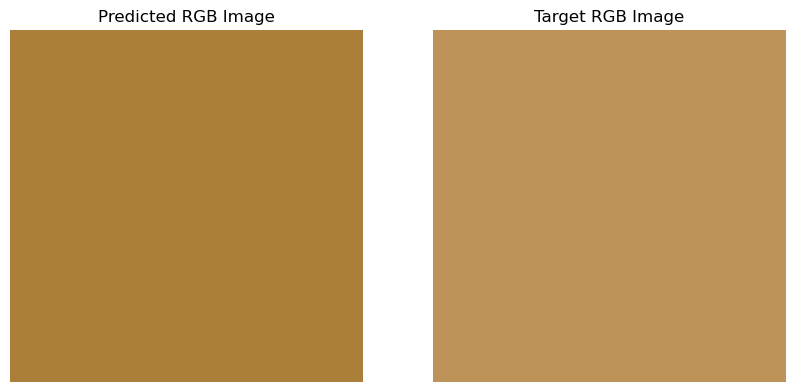

In [63]:
for i in range(0,10):
    # Create a blank image (100x100 pixels) with the RGB values
    output_image = np.zeros((100, 100, 3), dtype=np.uint8)
    output_image[:, :, 0] = y_pred[i][0]
    output_image[:, :, 1] = y_pred[i][1]
    output_image[:, :, 2] = y_pred[i][2]

    target_image = np.zeros((100, 100, 3), dtype=np.uint8)
    target_image[:, :, 0] = y_te[i][0]
    target_image[:, :, 1] = y_te[i][1]
    target_image[:, :, 2] = y_te[i][2]

    # Plot the images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot predicted RGB image
    axes[0].imshow(output_image)
    axes[0].set_title("Predicted RGB Image")
    axes[0].axis('off')  # Hide axes

    # Plot target RGB image
    axes[1].imshow(target_image)
    axes[1].set_title("Target RGB Image")
    axes[1].axis('off')  # Hide axes

    plt.show()

In [64]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x_tr_reshaped, y_tr)

# Make predictions
y_pred = regr.predict(x_te_reshaped)

mse = mean_squared_error(y_te, y_pred, multioutput='raw_values')
# Print shape of predictions
print("Shape of predictions:", y_pred.shape)
print("Mean Squared Errors for each target:", mse)

Shape of predictions: (11, 3)
Mean Squared Errors for each target: [1543.12747276 1894.66942781 1311.63229989]


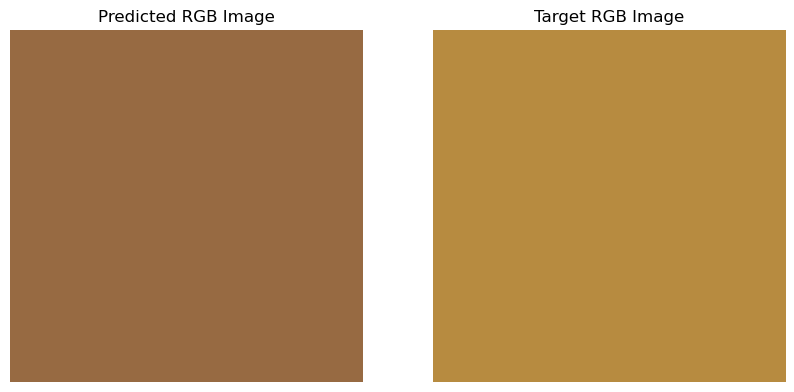

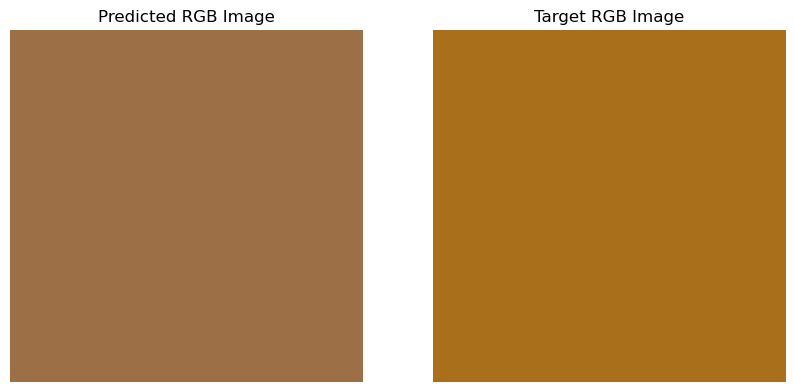

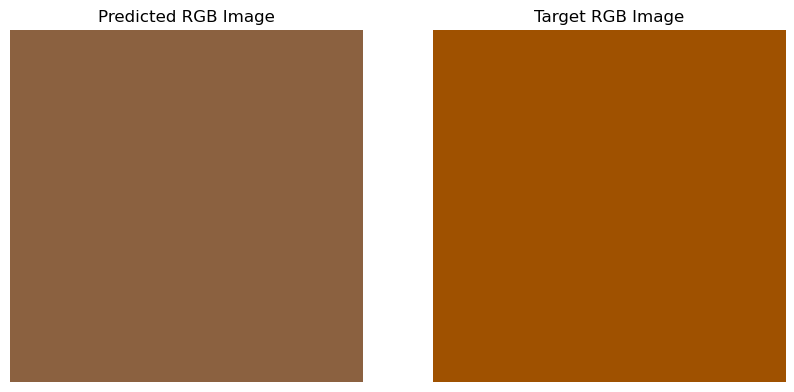

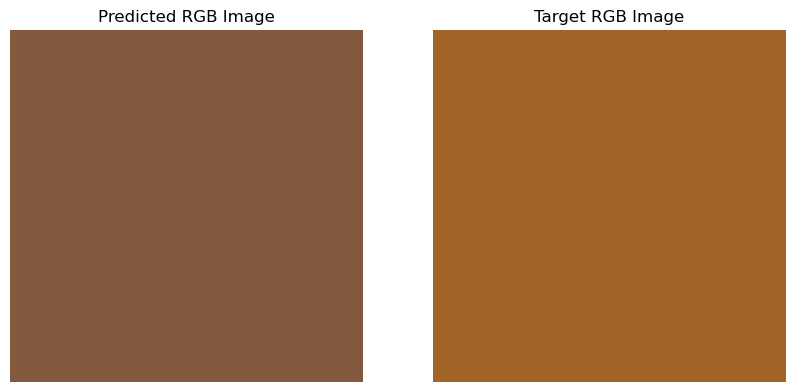

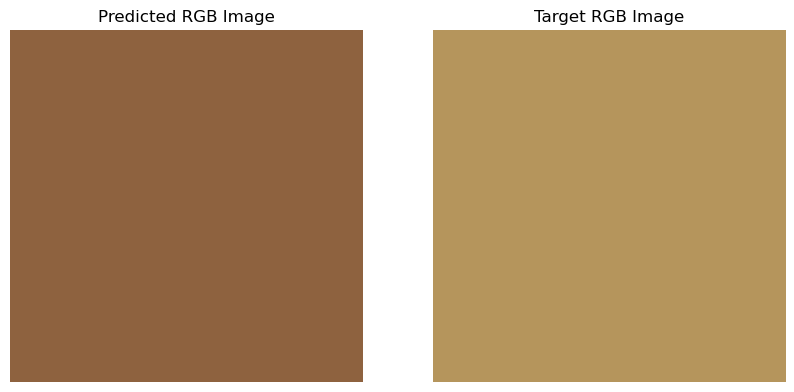

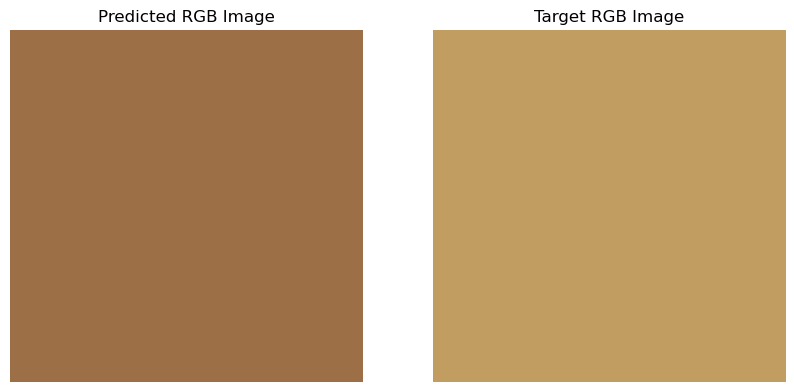

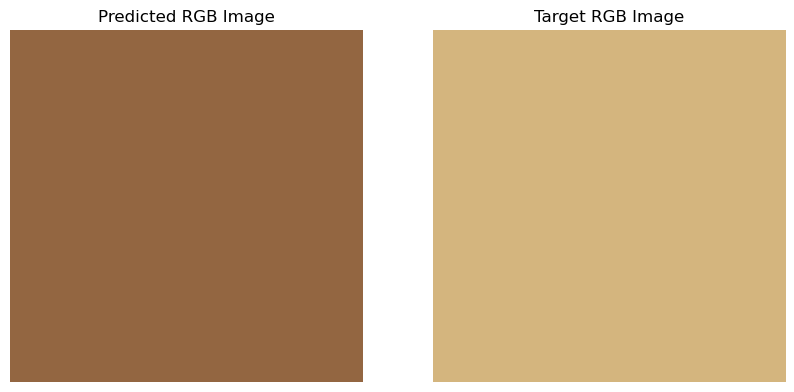

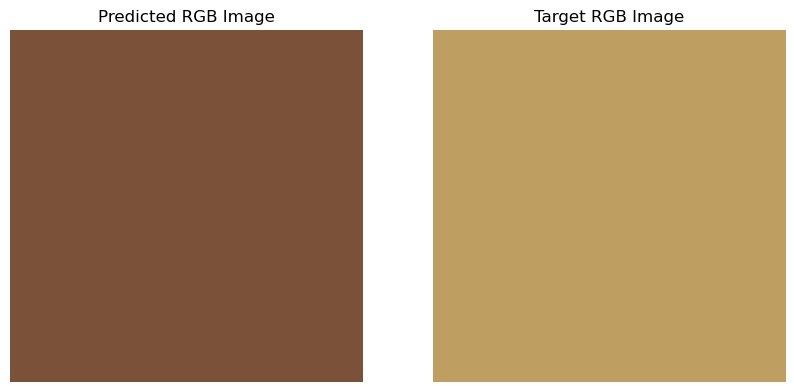

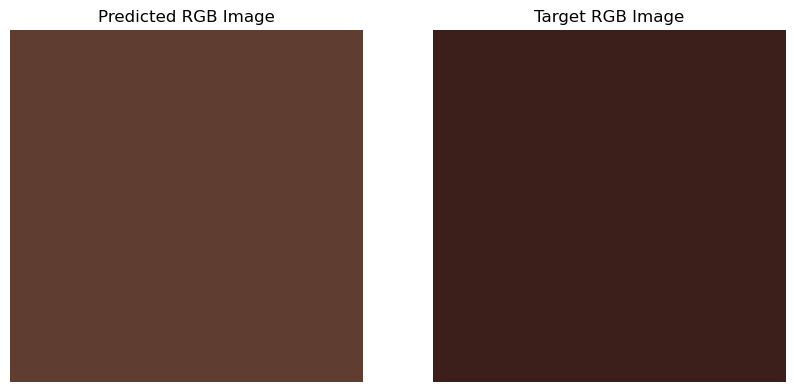

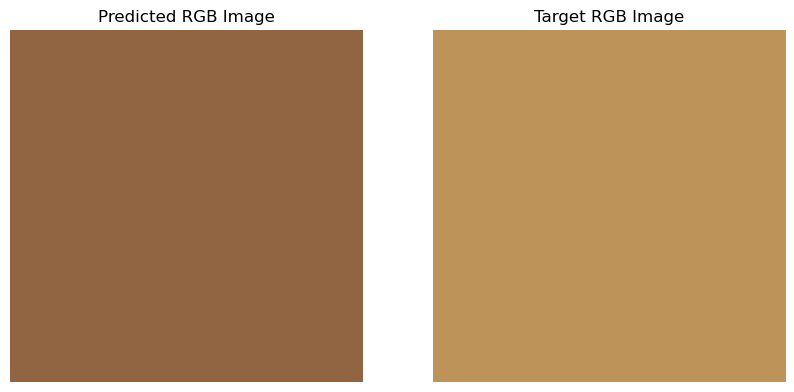

In [65]:
for i in range(0,10):
    # Create a blank image (100x100 pixels) with the RGB values
    output_image = np.zeros((100, 100, 3), dtype=np.uint8)
    output_image[:, :, 0] = y_pred[i][0]
    output_image[:, :, 1] = y_pred[i][1]
    output_image[:, :, 2] = y_pred[i][2]

    target_image = np.zeros((100, 100, 3), dtype=np.uint8)
    target_image[:, :, 0] = y_te[i][0]
    target_image[:, :, 1] = y_te[i][1]
    target_image[:, :, 2] = y_te[i][2]

    # Plot the images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot predicted RGB image
    axes[0].imshow(output_image)
    axes[0].set_title("Predicted RGB Image")
    axes[0].axis('off')  # Hide axes

    # Plot target RGB image
    axes[1].imshow(target_image)
    axes[1].set_title("Target RGB Image")
    axes[1].axis('off')  # Hide axes

    plt.show()

In [ ]:
models = []
mses = []

# Iterate over each channel (0, 1, 2)
for i in range(3):
    print('Runing model', i)
    # Extract features for channel `i`
    x_tr_channel = x_tr[:, i, :]  # Shape: (1001, 65536)
    x_te_channel = x_te[:, i, :]  # Shape: (test samples, 65536)

    # Extract targets for channel `i`
    y_tr_channel = y_tr[:, i]  # Shape: (1001,)
    y_te_channel = y_te[:, i]  # Shape: (test samples,)

    # Train model
    model = xgboost.XGBRegressor(n_estimators=500, max_depth=3)
    model.fit(x_tr_channel, y_tr_channel)
    models.append(model)

    # Predict and evaluate
    y_pred_channel = model.predict(x_te_channel)
    mse_channel = mean_squared_error(y_te_channel, y_pred_channel)
    mses.append(mse_channel)

# Print MSE for each channel
for i, mse_channel in enumerate(mses):
    print(f"MSE for channel {i}: {mse_channel}")

print("Average MSE:", np.mean(mses))

In [32]:
models = []
mses = []

# Iterate over each channel (0, 1, 2)
for i in range(3):
    print('Runing model', i)
    # Extract features for channel `i`
    x_tr_channel = x_tr[:, i, :]  # Shape: (1001, 65536)
    x_te_channel = x_te[:, i, :]  # Shape: (test samples, 65536)

    # Extract targets for channel `i`
    y_tr_channel = y_tr[:, i]  # Shape: (1001,)
    y_te_channel = y_te[:, i]  # Shape: (test samples,)

    # Train model
    model = xgboost.XGBRegressor(n_estimators=500, max_depth=3)
    model.fit(x_tr_channel, y_tr_channel)
    models.append(model)

    # Predict and evaluate
    y_pred_channel = model.predict(x_te_channel)
    mse_channel = mean_squared_error(y_te_channel, y_pred_channel)
    mses.append(mse_channel)

# Print MSE for each channel
for i, mse_channel in enumerate(mses):
    print(f"MSE for channel {i}: {mse_channel}")

print("Average MSE:", np.mean(mses))

Runing model 0


Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x297a6c2e0>>
Traceback (most recent call last):
  File "/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/xgboost/core.py", line 589, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument
KeyboardInterrupt: 
Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x297a6c2e0>>
Traceback (most recent call last):
  File "/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/xgboost/core.py", line 589, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument
KeyboardInterrupt: 


KeyboardInterrupt: 

In [35]:
y_pred_channel

array([85.88904 , 53.304073, 65.175156, ..., 53.621826, 44.272583,
       39.334   ], dtype=float32)

In [36]:
y_tr_channel

array([ 82., 118., 203., ..., 107.,  55.,  74.], dtype=float32)

In [38]:
mses

[]

### Using pre-trained model

In [83]:
model = models.resnet18(pretrained=True)  # Use smaller versions like resnet18 for faster fine-tuning
model.fc = nn.Linear(512, 3)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/lisavind/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:12<00:00, 3.75MB/s]


In [84]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [85]:
# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer (and any other layers you want to fine-tune)
for param in model.fc.parameters():
    param.requires_grad = True

In [107]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=50, shuffle=False, num_workers=8)

In [108]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:  # Assuming `train_loader` is your data loader
        optimizer.zero_grad()  # Zero the gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Calculate loss
        loss.backward()  # Backpropagate

        optimizer.step()  # Update model parameters

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/tor

Epoch [1/5], Loss: 1155.4481


/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/tor

Epoch [2/5], Loss: 1158.4541


/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/tor

Epoch [3/5], Loss: 1156.6975


/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/tor

Epoch [4/5], Loss: 1161.7573


/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/tor

Epoch [5/5], Loss: 1163.0630


In [109]:
model.eval()  # Set the model to evaluation mode
val_loss = 0.0

output_colors = []
target_colors = []
with torch.no_grad():  # No gradients needed for evaluation
    for inputs, targets in val_loader:  # Assuming `val_loader` is your validation data loader
        outputs = model(inputs)
        output_colors.append(outputs)
        target_colors.append(targets)
        loss = criterion(outputs, targets)
        val_loss += loss.item()

print(f'Validation Loss: {val_loss / len(val_loader):.4f}')

/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


Validation Loss: 1684.1332


In [112]:
output_colors

[tensor([[119.6250,  82.5834,  59.9187],
         [126.3850,  86.4696,  63.4284],
         [138.5142,  95.6371,  69.4076],
         [120.4063,  83.2328,  60.4574],
         [136.1157,  93.4818,  68.1401],
         [106.6258,  73.8710,  54.2045],
         [108.7093,  75.0551,  54.9429],
         [125.1668,  85.8308,  62.9965],
         [113.0987,  77.9678,  57.0423],
         [131.8258,  90.3710,  65.6608],
         [120.5777,  83.0103,  59.6841],
         [137.3586,  94.1724,  68.7019],
         [132.5871,  91.8594,  66.5655],
         [124.7084,  85.7199,  61.7935],
         [125.7234,  86.8775,  62.5661],
         [101.4177,  69.0870,  50.6399],
         [ 94.5486,  64.8102,  47.2140],
         [124.7834,  85.8715,  62.8441],
         [112.7759,  77.5311,  57.2683],
         [132.0877,  90.9437,  66.0934]])]

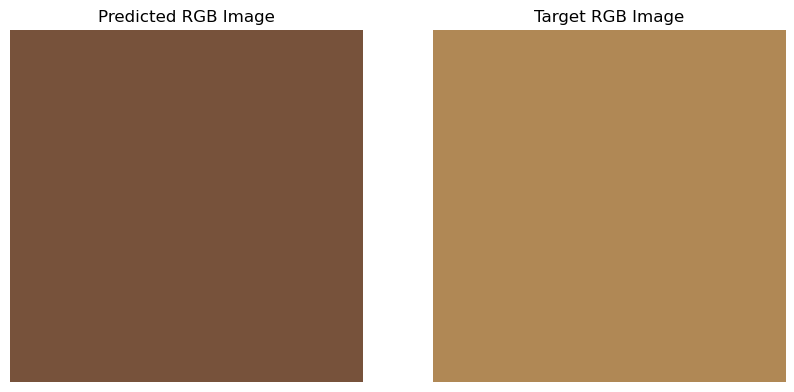

IndexError: list index out of range

In [111]:
for i in range(0,20):

    # Create a blank image (100x100 pixels) with the RGB values
    output_image = np.zeros((100, 100, 3), dtype=np.uint8)
    output_image[:, :, 0] = output_colors[i][0,0]
    output_image[:, :, 1] = output_colors[i][0,1]
    output_image[:, :, 2] = output_colors[i][0,2]

    target_image = np.zeros((100, 100, 3), dtype=np.uint8)
    target_image[:, :, 0] = target_colors[i][0,0]
    target_image[:, :, 1] = target_colors[i][0,1]
    target_image[:, :, 2] = target_colors[i][0,2]

    # Plot the images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot predicted RGB image
    axes[0].imshow(output_image)
    axes[0].set_title("Predicted RGB Image")
    axes[0].axis('off')  # Hide axes

    # Plot target RGB image
    axes[1].imshow(target_image)
    axes[1].set_title("Target RGB Image")
    axes[1].axis('off')  # Hide axes

    plt.show()

### Model for prediction of color using thorax RGB

In [39]:
class AlexNetInspired(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # Conv1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # MaxPool1
            nn.Conv2d(64, 192, kernel_size=5, padding=2),  # Conv2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # MaxPool2
            nn.Conv2d(192, 384, kernel_size=3, padding=1),  # Conv3
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # Conv4
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Conv5
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)  # MaxPool3
        )
        
        # Adaptive average pooling to fix the output size
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        # Regressor to predict RGB values (3 outputs)
        self.regressor = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),  # Flattening the output from feature extraction
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 3)  # RGB output
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x) 
        x = self.avgpool(x) 
        x = x.view(1, -1) #To flatten torch
        x = self.regressor(x)
        return x

In [73]:
idx = np.random.randint(len(train_dataset)) # random sample
image, label = train_dataset[idx]

x, y = image,label

In [74]:
print(y)

tensor([149., 106.,  71.])


In [76]:
model = AlexNetInspired()

In [77]:
logits = model(x)

In [80]:
print(logits)
print(type(logits))

tensor([[-0.0122, -0.0216, -0.0070]], grad_fn=<AddmmBackward0>)
<class 'torch.Tensor'>


In [81]:
class PLWrapper(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        print(y_hat, y)
        loss = F.mse_loss(y_hat, y)
        print(loss)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.mse_loss(y_hat, y)

        rmse = torch.sqrt(loss)
        self.log("val_rmse", rmse)
        self.log("val_loss", loss)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.01, weight_decay=0.01)


plmodel = PLWrapper(model)

tb_logger = pl_loggers.TensorBoardLogger(save_dir="logs/")

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='alexnet-{epoch}-{val_accuracy:.2f}',
    monitor="val_rmse",
    mode="max"
    )

trainer = pl.Trainer(max_epochs=1, accelerator="cpu", devices=1,
                     logger=tb_logger, callbacks=[checkpoint_callback])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)
trainer.fit(plmodel, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | AlexNetInspired | 57.0 M | train
--------------------------------------------------
57.0 M    Trainable params
0         Non-trainable params
57.0 M    Total params
228.065   Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/tor

Training: |          | 0/? [00:00<?, ?it/s]

/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/torchvision/transforms/functional.py:136: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/tor

tensor([[-0.0125, -0.0216, -0.0070]], grad_fn=<AddmmBackward0>) tensor([[174., 129.,  87.]])
tensor(18165.7129, grad_fn=<MseLossBackward0>)
tensor([[1.6538, 1.2186, 0.8221]], grad_fn=<AddmmBackward0>) tensor([[116.,  87.,  79.]])
tensor(8848.4248, grad_fn=<MseLossBackward0>)
tensor([[5722.4146, 4262.5107, 3555.5151]], grad_fn=<AddmmBackward0>) tensor([[115.,  87.,  75.]])
tensor(20330658., grad_fn=<MseLossBackward0>)
tensor([[-3.4545e+26, -2.5724e+26, -2.1442e+26]], grad_fn=<AddmmBackward0>) tensor([[99., 64., 60.]])
tensor(inf, grad_fn=<MseLossBackward0>)
tensor([[nan, nan, nan]], grad_fn=<AddmmBackward0>) tensor([[113.,  85.,  73.]])
tensor(nan, grad_fn=<MseLossBackward0>)
tensor([[nan, nan, nan]], grad_fn=<AddmmBackward0>) tensor([[74., 65., 60.]])
tensor(nan, grad_fn=<MseLossBackward0>)
tensor([[nan, nan, nan]], grad_fn=<AddmmBackward0>) tensor([[171., 103.,  54.]])
tensor(nan, grad_fn=<MseLossBackward0>)
tensor([[nan, nan, nan]], grad_fn=<AddmmBackward0>) tensor([[96., 61., 55.]])


Detected KeyboardInterrupt, attempting graceful shutdown ...


tensor([[nan, nan, nan]], grad_fn=<AddmmBackward0>) tensor([[74., 63., 59.]])
tensor(nan, grad_fn=<MseLossBackward0>)


NameError: name 'exit' is not defined

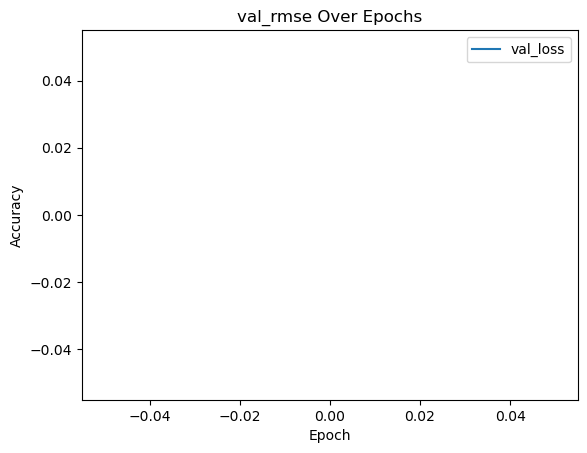

In [69]:
# Locate TensorBoard log file
log_dir = Path(tb_logger.log_dir)
events_file = list(log_dir.rglob("events.out.tfevents.*"))[0]

# Load the events
event_acc = EventAccumulator(str(events_file))
event_acc.Reload()

# Extract val_accuracy
val_acc_events = event_acc.Scalars("val_loss")
val_epochs = [e.step for e in val_acc_events]
val_values = [e.value for e in val_acc_events]

# Plot val_accuracy
plt.plot(val_epochs, val_values, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("val_rmse Over Epochs")
plt.legend()
plt.show()

In [70]:
print(val_values)

[nan, nan, nan, nan, nan]
